Collaborative Filtering incorporates the intersection of item and user information into the generation of recommendations. In this notebook, we go through an Item-Item, neighbourhood based model and a Matrix Factorization model. Both models are used to generate predictions of a user's rating on an unseen anime. Recommendations are then made by sorting the predicted rating from highest to lowest.

## Load Data

The dataset is the users-score-2023.csv file from https://www.kaggle.com/datasets/dbdmobile/myanimelist-dataset/

In [4]:
import pandas as pd

ratings = pd.read_csv('users-score-2023.csv')

In [5]:
ratings.head()

,user_id,Username,anime_id,Anime Title,rating
0,1,Xinil,21,One Piece,9
1,1,Xinil,48,.hack//Sign,7
2,1,Xinil,320,A Kite,5
3,1,Xinil,49,Aa! Megami-sama!,8
4,1,Xinil,304,Aa! Megami-sama! Movie,8


## Item-item collaborative filtering

 Predict the rating of an anime that a user has not rated by using the similarities between the user's rated anime and the current anime to be rated.

First, to find the similarity between anime we treat each column of ratings for each anime as its feature vector, and compute similarity based on similar feature vectors.

In [6]:
import numpy as np

def get_similarity(anime1, anime2, ratings):
    # Filter the ratings for each anime
    anime1_ratings = ratings[ratings['Anime Title'] == anime1]
    anime2_ratings = ratings[ratings['Anime Title'] == anime2]

    # Use the intercept from inner merge to find ratings by users who rated both anime
    shared_ratings = pd.merge(anime1_ratings, anime2_ratings, how = 'inner', on='user_id', suffixes=('_anime1', '_anime2'))
    #print(shared_ratings.head())

    # Extract the shared ratings for each anime
    anime1_sharedratings = shared_ratings['rating_anime1']
    anime2_sharedratings = shared_ratings['rating_anime2']

    if anime1_sharedratings.empty or anime2_sharedratings.empty:
        cosine_similarity = 0
    else:
        cosine_similarity = np.dot(anime1_sharedratings, anime2_sharedratings) / (np.linalg.norm(anime1_sharedratings) * np.linalg.norm(anime2_sharedratings))
    return cosine_similarity

In [7]:
anime = ['One Piece', 'Love Hina', 'Jujutsu Kaisen']

similarities = {}

for ani in anime:
    similarities[ani] = get_similarity(anime[0], ani, ratings)

sorted_anime = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
sorted_anime

[('One Piece', 1.0),
 ('Jujutsu Kaisen', 0.9817785028531196),
 ('Love Hina', 0.9649159213317992)]

While the similarity scores are all relatively high, One Piece is expectedly calculated as more similar to Jujutsu Kaisen than Love Hina.

Now, we predict the rating of the unrated anime via a similarity weighted average of the user's rated anime

In [8]:
def item_item_recommender(user_id, n_recs, n_items, ratings):
    np.random.seed(42)

    user_ratings = ratings[ratings['user_id'] == user_id]
    anime_rated = user_ratings['Anime Title'].unique()
    anime_not_rated = ratings[-ratings['Anime Title'].isin(anime_rated)]['Anime Title'].unique()
    user_ratings = user_ratings.sample(n_items, replace=False, random_state=42) # how many neighbors to use
    anime_rated = user_ratings['Anime Title'].unique()
    anime_ratings = user_ratings['rating']
    recs = np.random.choice(anime_not_rated, n_recs, replace=False) # how many recommendations to make
    

    predicted_ratings = []

    for rec in recs:
        similarities = []
        for ani in anime_rated:
            similarities.append(get_similarity(rec, ani, ratings))
        
        similarities = np.array(similarities)
        anime_ratings = np.array(anime_ratings)
        # print(similarities, anime_ratings)
        predicted_ratings.append(np.dot(similarities, anime_ratings) / np.sum(similarities))

    sorted_recs_with_pred_ratings = sorted(dict(zip(recs, predicted_ratings)).items(), key=lambda x: x[1], reverse=True)

    return sorted_recs_with_pred_ratings

In [9]:
animerecs = item_item_recommender(1, 20, 20, ratings)
animerecs

[('Fast Week', 7.6),
 ('Ookami Shounen Ken', 7.503787451358199),
 ('Tetsujin 28-gou: Hakuchuu no Zangetsu', 7.351326865114048),
 ('Onikiri Shoujo', 7.333333333333333),
 ('Go-Q-Choji Ikkiman', 7.329837014167806),
 ('Nineko Gelée', 7.253828290173994),
 ('Ekaki Uta', 7.25),
 ('Inuyashiki', 7.103799456978764),
 ('Tennis no Ouji-sama: Zenkoku Taikai-hen - Semifinal', 7.1025417965318525),
 ('High School DxD Hero: Taiikukan-ura no Holy', 7.101989350212257),
 ('Mahouka Koukou no Rettousei', 7.100164554761387),
 ('Blue Dragon', 7.098669893105704),
 ('Escha & Logy no Atelier: Tasogare no Sora no Renkinjutsushi',
  7.098415229806498),
 ('Saint Seiya: Kamigami no Atsuki Tatakai', 7.098284530886654),
 ('Doubutsu Tonarigumi', 7.097925087738627),
 ('Di Gi Charat Summer Special 2000', 7.097398693962211),
 ('Peter Grill to Kenja no Jikan', 7.0941255356444515),
 ('Anata mo Robot ni Nareru feat. Kamome Jidou Gasshoudan', 7.093156937105979),
 ('Ninkuu (Movie)', 7.0926872968613415),
 ('A.LI.CE', 7.08324987

^ notice how the more obscure anime are rated higher? its prob not because the user actually has such esoteric preferences, but rather due to the item-item method being heavily affected by sparsity. We can plot the frequency of ratings for each anime to verify this.

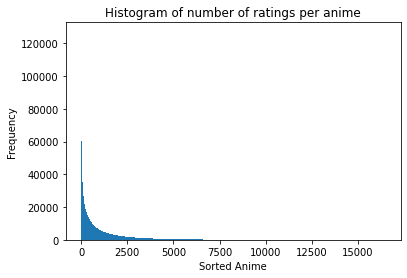

In [10]:
import matplotlib.pyplot as plt

plt.bar(range(len(ratings['anime_id'].value_counts())), ratings['anime_id'].value_counts().values, width=1.0)
plt.xlabel('Sorted Anime')
plt.ylabel('Frequency')
plt.title('Histogram of number of ratings per anime')
plt.show()

We see that more than half of the anime have frequencies so low, they dont even appear on the graph! This suggests a concerning level of sparsity which could affect similarity calculations from the lack of information. As a heuristic, we can filter out the anime that are less frequent than some arbitrary level, which here we take as the median — 83 ratings. For the remaining 50% of less frequent anime, perhaps a content-based recommender system would be more suitable.

In [11]:
ratings = ratings.groupby('anime_id').filter(lambda x: len(x) >= 83)

In [12]:
animerecs = item_item_recommender(1, 20, 20, ratings)
animerecs

[('Shin Mitsubachi Maya no Bouken', 7.284355453637447),
 ('Mazinkaiser: Shitou! Ankoku Dai Shogun', 7.106541181024469),
 ('Shokugeki no Souma: Gou no Sara', 7.1059049039782645),
 ('Hana yori Dango', 7.105850859414536),
 ('Fella Hame Lips', 7.103646210302796),
 ('Koi wa Sekai Seifuku no Ato de', 7.103385289012879),
 ('Bleach: The Sealed Sword Frenzy', 7.1022375656703804),
 ('Maid of the Dead', 7.101680295211591),
 ('Shin Getter Robo tai Neo Getter Robo', 7.101138788053717),
 ('Survival', 7.099624436027016),
 ('City Hunter: Kinkyuu Namachuukei!? Kyouakuhan Saeba Ryou no Saigo',
  7.099583126820753),
 ('Akebi no Hana: Maho', 7.0995083421604),
 ('Konnichiwa Anne: Before Green Gables', 7.098420168817938),
 ('Narue no Sekai', 7.097936247161032),
 ('Heartwork: Symphony of Destruction', 7.096767968098375),
 ('Penguin Musume♥Heart', 7.096234808488256),
 ('Rokumon Tengai Mon Colle Knights', 7.093737043605895),
 ('Yume no Kakera', 7.093435026905165),
 ('Transformers Superlink', 7.091378529178498)

Other than the first recommendation(idk wtf happened there), it seems that user 1 likes shounen anime more than female-protagonist anime, and hence has a taste similar to that of a male teenager.

## Matrix Factorization

Find a lower-dimensional embedding for users and animes such that the scaled(here sigmoid) dot product of a pair of (user,anime) embeddings, is close to the actual rating of the user for that anime. The learnt embeddings can then be used to approximate the ratings of users for unrated anime. To quote Simon Funk for intuition behind why this would work,

"If meaningful generalities can help you represent your data with fewer numbers, finding a way to represent your data in fewer numbers can often help you find meaningful generalities. Compression is akin to understanding and all that."

which is an idea that is relatively prominent in ML.

Before we start the modeling, interestingly we see that for whatever reason the authors of the dataset skipped certain integers when assigning user_id and anime_id values. e.g. there is anime with anime_id 1,5,6 but no anime with anime_id 2,3,4. 

In [13]:
a = ratings['anime_id'].unique()
a.sort()
a

array([    1,     5,     6, ..., 55016, 55351, 55818], dtype=int64)

Indeed, id needs only be unique to fulfill its categorical purpose, and theres no technical need to adhere to a non-skipped mapping of id. So its technically plausible to proceed to the modelling with the current dataset. However, for the sake of better fitting the matrix analogy in matrix factorization, we change the ids to a non-skipped integer mapping such that one can interpret a user_id of i and an anime_id of j as the ith row and jth column of the feedback matrix respectively.

In [14]:
ratings['user_id'] = ratings['user_id'].map({old: new + 1 for new, old in enumerate(ratings['user_id'].unique())})
ratings['anime_id'] = ratings['anime_id'].map({old: new + 1 for new, old in enumerate(ratings['anime_id'].unique())})
ratings

,user_id,Username,anime_id,Anime Title,rating
0,1,Xinil,1,One Piece,9
1,1,Xinil,2,.hack//Sign,7
2,1,Xinil,3,A Kite,5
3,1,Xinil,4,Aa! Megami-sama!,8
4,1,Xinil,5,Aa! Megami-sama! Movie,8
...,...,...,...,...,...
24325186,269934,Oblongata,3356,R-15,3
24325187,269934,Oblongata,210,Tenjou Tenge,6
24325188,269935,JuunanaSai,244,Death Note,9
24325189,269935,JuunanaSai,38,Elfen Lied,10


Much better! (I Cope) 

Now onto the modelling

In [15]:
from torch.utils.data import Dataset, DataLoader

class dfDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        user_id = self.df.iloc[idx, 0]
        anime_id = self.df.iloc[idx, 2]
        rating = self.df.iloc[idx, 4]
        return [user_id, anime_id, rating]
    
ratings_dataset = dfDataset(ratings)
ratings_dataloader = DataLoader(ratings_dataset, batch_size=8192, shuffle=True) # more on the batch size ltr

In [16]:
len(ratings)

24177139

In [17]:
import torch
import torch.nn as nn
from torch import sigmoid

class MFModel(nn.Module):
    def __init__(self, n_users, n_anime, n_dim=20):
        super().__init__()
        self.user_embs = nn.Embedding(n_users, n_dim, sparse=True)
        self.user_embs_bias = nn.Embedding(n_users, 1, sparse=True)
        self.anime_embs = nn.Embedding(n_anime, n_dim, sparse=True)
        self.anime_embs_bias = nn.Embedding(n_anime, 1, sparse=True)
        
    def forward(self, user, anime):
        return sigmoid((self.user_embs(user-1) * self.anime_embs(anime-1)).sum(1)) + self.user_embs_bias(user-1).squeeze() + self.anime_embs_bias(anime-1).squeeze()
    
model = MFModel(len(ratings['user_id'].unique()), len(ratings['anime_id'].unique()))


While waiting for my crappy pc to train the model, i was curious whether increasing the batch size would lead to faster training with linear algebra being more computationally efficient and what not, and if so to what extent. So i set a few variables for timing the difference(which ive commented out for the sake of output brevity) but the end result is that: in terms of the time it takes to do a training loop, larger batches are overwhelmingly more time efficient, like an eyeball estimate of 0.005s/loop with a 1024 batch size vs 0.07s=0.005*14/loop with a 65536=1024\*64 batch size. However, because the data fetching takes roughly a linear amount of time w/ respect to number of rows fetched, the time taken becomes predominantly contributed by data fetching as batch size is increased and hence the difference from training loop time becomes quickly irrelevant. tldr, it doesnt bcs O(n + logn) = O(n)

In [18]:
for batch in ratings_dataloader:
    print(batch[0].shape)
    break

torch.Size([8192])


In [19]:
import time
optimizer = torch.optim.SparseAdam(model.parameters(), lr=0.005)
criterion = nn.MSELoss()
#starttwo = 0
for epoch in range(5):
    for batch in ratings_dataloader:
        #start = time.time()
        #endtwo = time.time()
        #print(f'Data fetch time = {endtwo-starttwo}')
        optimizer.zero_grad()
        user, anime, rating = batch
        rating = torch.tensor(rating, dtype=torch.float32)
        pred = model(user, anime)
        loss = criterion(pred, rating)
        loss.backward()
        optimizer.step()
        #end = time.time()
        #print(f'Backward pass time = {end-start}')
        #starttwo = time.time()
    print(loss.item())
    torch.save(model.state_dict(), 'model_weights.pth'+str(epoch))

C:\Users\Lim Jia Hui\AppData\Local\Temp\ipykernel_29820\3202941603.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rating = torch.tensor(rating, dtype=torch.float32)


3.2623353004455566
2.0558974742889404
1.793753981590271
1.7959517240524292
1.6500691175460815


Note that i didn't do a validation split here, which is mostly due to the dataset not having a convenient way of splitting while ensuring the train split would still have a 'sufficient' representation of the rating. One way to do said splitting would be to split by date, and for serious applications it would be very much beneficial to do said validation split by date. 

In [20]:
import numpy as np
def matrix_fac_recommender(user_id, n_recs, ratings):
    np.random.seed(42)

    user_ratings = ratings[ratings['user_id'] == user_id]
    anime_rated = user_ratings['Anime Title'].unique()
    anime_not_rated = ratings[-ratings['Anime Title'].isin(anime_rated)].drop_duplicates(subset=['Anime Title'])
    recs = anime_not_rated.loc[:, ['Anime Title', 'anime_id']].sample(n_recs, replace=False, random_state=42).set_index('Anime Title')['anime_id'].to_dict() # how many recommendations to make
    predicted_ratings = []
    
    for rec in recs.values():
        predicted_ratings.append(model(torch.tensor(user_id).unsqueeze(dim=0), torch.tensor(rec).unsqueeze(dim=0)).item())

    sorted_recs_with_pred_ratings = sorted(dict(zip(recs.keys(), predicted_ratings)).items(), key=lambda x: x[1], reverse=True)

    return sorted_recs_with_pred_ratings

In [21]:
ratings[ratings['user_id'] == 1].loc[ratings['Anime Title'] == 'Azumanga Daiou The Animation', ['Anime Title', 'rating']]

,Anime Title,rating
238,Azumanga Daiou The Animation,6


In [22]:
matrix_fac_recommender(1, 20, ratings)

[('Hana yori Dango', 7.775703430175781),
 ('City Hunter: Kinkyuu Namachuukei!? Kyouakuhan Saeba Ryou no Saigo',
  7.522305488586426),
 ('Mazinkaiser: Shitou! Ankoku Dai Shogun', 7.086770057678223),
 ('Koi wa Sekai Seifuku no Ato de', 7.007019996643066),
 ('Bleach: The Sealed Sword Frenzy', 6.788742542266846),
 ('Penguin Musume♥Heart', 6.640021324157715),
 ('Narue no Sekai', 6.462850570678711),
 ('Survival', 6.2981719970703125),
 ('Shokugeki no Souma: Gou no Sara', 6.217508792877197),
 ('Shin Getter Robo tai Neo Getter Robo', 6.141360282897949),
 ('Transformers Superlink', 6.00144100189209),
 ('Konnichiwa Anne: Before Green Gables', 5.788362503051758),
 ('Shin Mitsubachi Maya no Bouken', 5.187295913696289),
 ('Heartwork: Symphony of Destruction', 5.160801887512207),
 ('Rokumon Tengai Mon Colle Knights', 5.035014629364014),
 ('Maid of the Dead', 5.001959800720215),
 ('Yume no Kakera', 4.022702217102051),
 ('Akebi no Hana: Maho', 3.9003677368164062),
 ('Vampire', 3.725501775741577),
 ('Fe

We see that theres greater variation in the ratings score, which would indicate a possibly more accurate rating prediction. We see that once more the recommendations are mostly shounen-style, with now a more pronounced preference for action/adventure-themed(and perhaps some "Cute Girls Doing Cute Things" themed) anime and less so for adult/romance themed anime

### References

https://www.kaggle.com/code/jhoward/collaborative-filtering-deep-dive#Collaborative-Filtering-from-Scratch
https://www.kaggle.com/code/ibtesama/getting-started-with-a-movie-recommendation-system#Collaborative-Filtering
https://www.geeksforgeeks.org/item-to-item-based-collaborative-filtering/
https://www.kaggle.com/code/rounakbanik/movie-recommender-systems
